**Project Description**
This project builds a machine‑learning system to predict whether a university student is likely to graduate or drop out, based on their academic performance and administrative data. By leveraging historical student records (e.g. course approvals, grades, tuition-payment status, and age at enrollment), we train an XGBoost classifier—tuned via manual, grid, randomized, and Optuna‑based searches—to achieve robust accuracy in distinguishing “graduate” from “dropout” cases.

**Reasons for this project**
* **Early Intervention:** Identifying at‑risk students before they disengage allows universities to offer targeted support (tutoring, counseling, financial aid) and improve retention.
* **Resource Optimization:** By knowing which factors most influence persistence, administrators can prioritize programs and allocate resources where they’ll have the greatest impact.
* **Data‑Driven Strategy:** Moving beyond anecdotal decision‑making, this predictive tool empowers stakeholders to make informed policy and academic‑advising choices grounded in quantitative evidence.


In [155]:
#Import important libraries
# 📦 Data Manipulation
import pandas as pd                  # Used for handling tabular data (DataFrames)
import numpy as np                   # Used for numerical operations, arrays, and matrices

# 📊 Data Visualization
import matplotlib.pyplot as plt      # For creating basic visualizations like plots and charts
import seaborn as sns                # For advanced, beautiful statistical plots (like heatmaps)

# 🧹 Data Preprocessing & Sampling
from sklearn.model_selection import (
    train_test_split,                # Splits dataset into training and testing sets
    cross_val_score,                 # Performs cross-validation
    GridSearchCV,                    # For hyperparameter tuning using grid search
    RandomizedSearchCV               # For faster hyperparameter tuning using random search
)
from sklearn.preprocessing import StandardScaler       # Standardizes features (scaling)
from sklearn.utils import resample                     # For undersampling majority class
from imblearn.over_sampling import SMOTE               # For oversampling the minority class (balancing)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier




# 🤖 Modeling
from xgboost import XGBClassifier                      # Your main classification model (XGBoost)
# 🧪 Model Evaluation
from sklearn.metrics import (
    accuracy_score,                  # Accuracy metric
    precision_score,                 # Precision metric
    recall_score,                    # Recall metric
    f1_score,                        # F1 score (harmonic mean of precision and recall)
    confusion_matrix,               # Confusion matrix
    ConfusionMatrixDisplay,         # Visual display of the confusion matrix
    classification_report,          # Full classification metrics report
    precision_recall_curve,         # Data for precision-recall curve
    roc_curve,                      # ROC curve values
    auc                             # Area Under Curve for ROC
)

# 🧠 Hyperparameter Optimization
import optuna                         # For automated hyperparameter tuning using Optuna trials

# 💾 Model Deployment
import joblib                         # For saving and loading machine learning models

# ⚠️ Warnings
import warnings
warnings.filterwarnings('ignore')     # Suppresses warning messages for cleaner output


In [157]:
#Step1: Load and view dataset 
df = pd.read_csv("Students_dropout.csv", sep=";")
df.head()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [159]:
df.shape

(4424, 37)

In [161]:
# Show all columns and first few rows
pd.set_option('display.max_columns', None)
print(df.head())

   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                         

In [163]:
# Check basic structure
print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nColumn Names:")
print(df.columns)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Remove duplicates
print("\nDuplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)


Dataset Shape: (4424, 37)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   F

In [165]:
print (df ['Target'].value_counts())


Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


In [59]:
#Step 2: Data Visualization

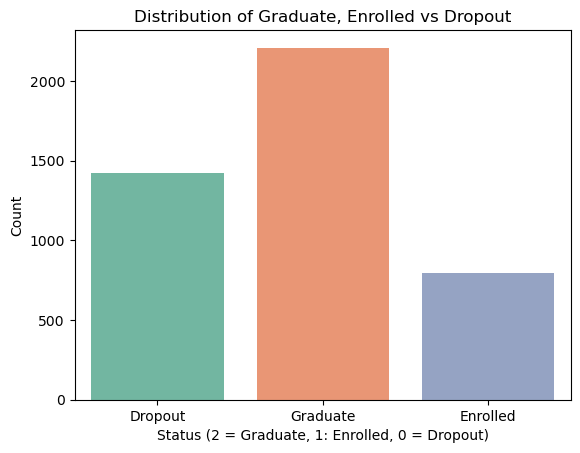

In [167]:
#Visualizing Target Variable 
Distributionsns.countplot(x='Target', data=df, palette='Set2')
plt.title("Distribution of Graduate, Enrolled vs Dropout")
plt.xlabel("Status (2 = Graduate, 1: Enrolled, 0 = Dropout)")
plt.ylabel("Count")
plt.show()


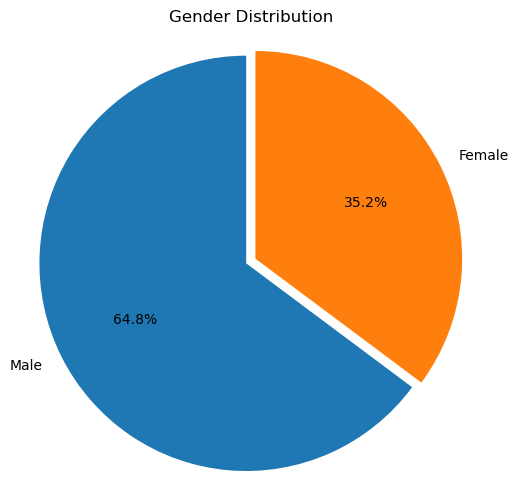

In [169]:
#Gender Breakdown of Students"
#  Replace 0/1 in Gender

if df['Gender'].dtypes != 'O':
    df['Gender'] = df['Gender'].map({0: 'Male', 1: 'Female'})

gender_counts = df['Gender'].value_counts()
labels = gender_counts.index
sizes = gender_counts.values

plt.figure(figsize=(6, 6))
explode = [0.05 if size == max(sizes) else 0 for size in sizes]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title("Gender Distribution")
plt.axis('equal')
plt.show()

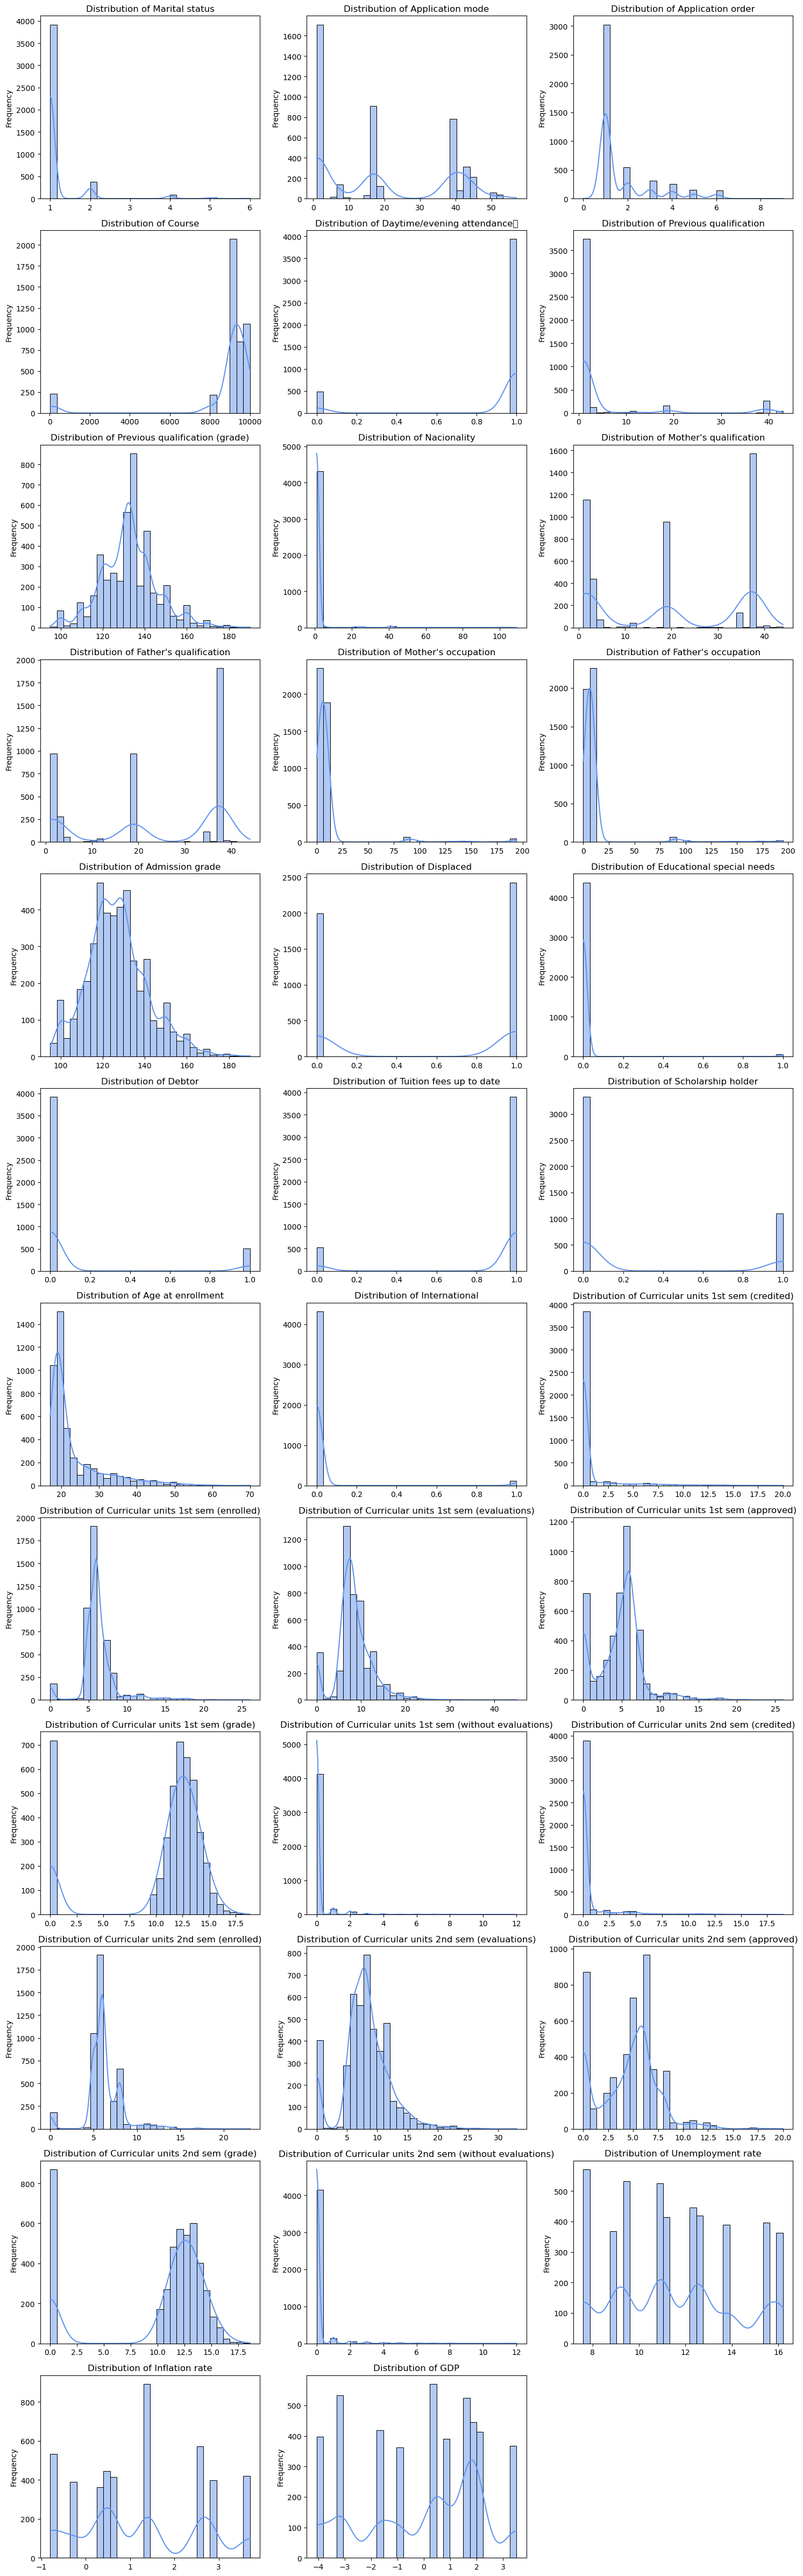

In [171]:
#Visualizing Numeric Data Distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

# Set up the grid size
n_cols = 3
n_rows = -(-len(numeric_features) // n_cols)  # Ceiling division

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop through all numeric features
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[feature], bins=30, kde=True, color='cornflowerblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [173]:
#Step 3: Data Preprocessing for Dropout Analysis
import pandas as pd

# 0) Load your data (adjust path & sep as needed)
df = pd.read_csv("Students_dropout.csv", sep=";")

# 1) Show original counts (string labels)
print("Original Target counts:")
print(df['Target'].value_counts(), "\n")

# 2) Filter out 'Enrolled'
df = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()

# 3) Show counts still in string form
print("After filtering out 'Enrolled':")
print(df['Target'].value_counts(), "\n")

# 4) Reset index
df.reset_index(drop=True, inplace=True)

# 5) Map Graduate→1, Dropout→0
df['Target'] = df['Target'].map({'Graduate': 1, 'Dropout': 0})

# 6) Verify the numeric mapping
print("After encoding to 0/1:")
print(df['Target'].value_counts())
print("\nUnique values and dtype:", df['Target'].unique(), df['Target'].dtype)

Original Target counts:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64 

After filtering out 'Enrolled':
Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64 

After encoding to 0/1:
Target
1    2209
0    1421
Name: count, dtype: int64

Unique values and dtype: [0 1] int64


In [81]:
#Step 4: Feature Scaling

In [175]:
#Scaling Features with StandardScaler
from sklearn.preprocessing import StandardScaler

x = df.drop('Target', axis=1)
y = df['Target']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)



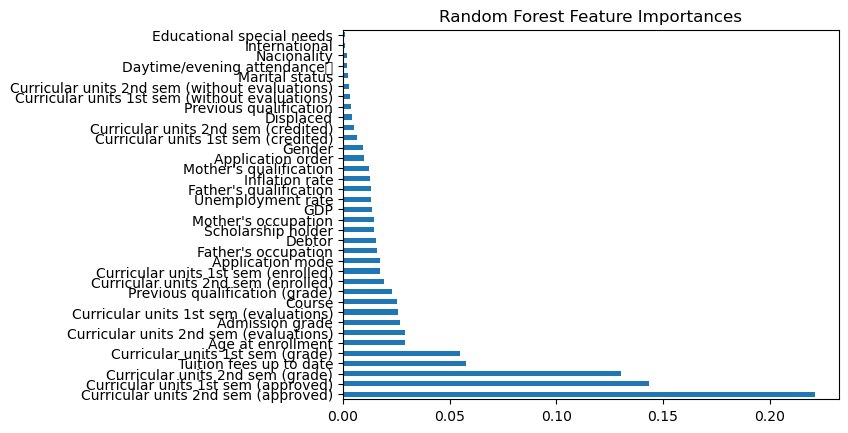

Top Features by Random Forest:
Curricular units 2nd sem (approved)               0.221419
Curricular units 1st sem (approved)               0.143407
Curricular units 2nd sem (grade)                  0.130500
Tuition fees up to date                           0.057659
Curricular units 1st sem (grade)                  0.055081
Age at enrollment                                 0.029162
Curricular units 2nd sem (evaluations)            0.028981
Admission grade                                   0.026809
Curricular units 1st sem (evaluations)            0.025730
Course                                            0.025552
Previous qualification (grade)                    0.023203
Curricular units 2nd sem (enrolled)               0.019088
Curricular units 1st sem (enrolled)               0.017502
Application mode                                  0.017381
Father's occupation                               0.016110
Debtor                                            0.015351
Scholarship holder       

In [177]:
#STEP 5: Feature Importance Using Random Scaling
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

#split feature and target
x = df.drop('Target', axis=1)
y = df['Target']

#scale the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#fit the random forest
rf = RandomForestClassifier()
rf.fit(x_scaled, y)

importances = rf.feature_importances_
features = pd.Series(importances, index=x.columns)
features.sort_values(ascending=False).plot(kind='barh', title="Random Forest Feature Importances") 
plt.show()

print("Top Features by Random Forest:")
print(features.sort_values(ascending=False))               

In [179]:
# SelectKbeast
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 6 features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=6)
x_kbest = selector.fit_transform(x_scaled, y)

# Get selected feature names
selected_kbest = x.columns[selector.get_support()]
print("Selected Features (SelectKBest):", selected_kbest.tolist())


Selected Features (SelectKBest): ['Tuition fees up to date', 'Scholarship holder', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']


In [181]:
#Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=6)
rfe.fit(x_scaled, y)

selected_rfe =x.columns[rfe.support_]
print("Selected Features (RFE):", selected_rfe.tolist())

Selected Features (RFE): ['Tuition fees up to date', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (approved)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)']


In [183]:
#Forward Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
sfs_forward = SequentialFeatureSelector(logreg, n_features_to_select=4, direction='forward')
sfs_forward.fit(x_scaled, y)

selected_forward = x.columns[sfs_forward.get_support()]
print("Selected Features (Forward Selection):", selected_forward.tolist())


Selected Features (Forward Selection): ['Debtor', 'Tuition fees up to date', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)']


In [189]:
#Backward feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
sfs_backward = SequentialFeatureSelector(logreg, n_features_to_select=4, direction='backward')
sfs_backward.fit(x_scaled, y)

selected_backward = x.columns[sfs_backward.get_support()]
print("Selected Features (Backward Elimination):", selected_backward.tolist())

Selected Features (Backward Elimination): ['Tuition fees up to date', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)', 'Curricular units 2nd sem (approved)']


In [191]:
#STEP 6: Train-Test Split. W split the data into training and testing sets using train_test_split

from sklearn.model_selection import train_test_split

#split the scaled data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42, stratify=y)

#confirm split sizes
print("Training Set Shape:", x_train.shape)
print("Testing Set Shape:", x_test.shape)  

#Lets check the shape of each split to understand the sizes
print("x_train shape:", x_train.shape)    #Feature for training 80% of rows
print("x_test shape:", x_test.shape)      #Feature for testing 20% of rows
print("y_train shape:", y_train.shape)    #Labels for training set
print("y_test shape:", y_test.shape)      #Labels for test set

Training Set Shape: (2904, 36)
Testing Set Shape: (726, 36)
x_train shape: (2904, 36)
x_test shape: (726, 36)
y_train shape: (2904,)
y_test shape: (726,)


In [195]:
#This code trains a basic Logistic Regression model on the training data
#and evaluates its performance on the test data.

#Step 7: Train a Basic Model(Logistic Regresson)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Train the model
model = LogisticRegression()
model.fit(x_train, y_train)

#Predict on test set
y_pred = model.predict(x_test)

#Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9146005509641874

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.88       284
           1       0.90      0.96      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.91      0.91       726



In [ ]:
Step 8: Visualize Confusion Matrix

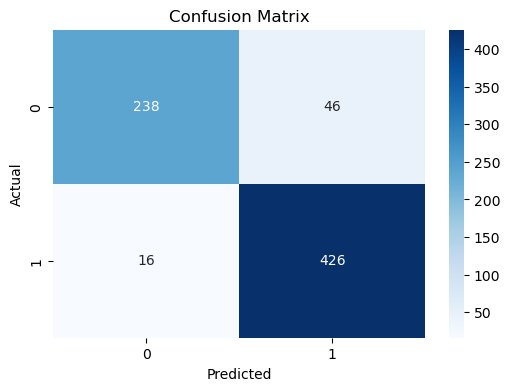

In [197]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are defined
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
          

|                          | **Predicted: Dropout (0)** | **Predicted: Graduate (1)** | **Total Actual** |
| ------------------------ | -------------------------- | --------------------------- | ---------------- |
| **Actual: Dropout (0)**  | 238 (**True Negatives**)   | 46 (**False Positives**)    | 284              |
| **Actual: Graduate (1)** | 16 (**False Negatives**)   | 426 (**True Positives**)    | 442              |
| **Total Predicted**      | 254                        | 472                         | 726              |


In [199]:
pip install xgboost

In [201]:
#Step 9 Training an XGBoost Classifier"
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(x_train, y_train)

xgb_pred = xgb_model.predict(x_test)

print("\n XGBoost")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))



 XGBoost
Accuracy: 0.9049586776859504
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       284
           1       0.89      0.96      0.93       442

    accuracy                           0.90       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.90      0.90       726



XGBoost Model Performance Discussion

Accuracy: The XGBoost model achieves an accuracy of 0.9049, which is slightly lower than the Logistic Regression model's accuracy of 0.9146.

Classification Report:

- Class 0 (Dropout):
    - Precision: 0.94 (high precision, similar to Logistic Regression)
    - Recall: 0.81 (lower recall compared to Logistic Regression, indicating more Dropout cases might be misclassified)
    - F1-score: 0.87 (slightly lower F1-score compared to Logistic Regression)
- Class 1 (Graduate):
    - Precision: 0.89 (high precision, similar to Logistic Regression)
    - Recall: 0.96 (high recall, similar to Logistic Regression)
    - F1-score: 0.93 (high F1-score, similar to Logistic Regression)


In [205]:
#STEP 10: Standardizing Features with StandardScaler
from sklearn.preprocessing import StandardScaler  # Fixed class name

# Separate features and target
x = df.drop('Target', axis=1)
y = df['Target']

# Standardize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)  # Fixed method call


In [207]:
import joblib
#After training your xgb_model
joblib.dump(xgb_model, "xgb_dropout_model.pkl")

['xgb_dropout_model.pkl']

['xgb_dropout_model.pkl'] a file containing a saved XGBoost model, specifically trained for predicting student dropout.



In [209]:
#Step 11: Sample Prediction Test
#This code makes predictions on a single sample from the test dataset using a trained model.


row_index = 25  # or 1, 2, etc.

# For NumPy array features:
sample = x_test[row_index].reshape(1, -1)

# Predict label and probability
predicted_label = model.predict(sample)[0]
predicted_prob = model.predict_proba(sample)[0][1]  # probability for class 1

# For pandas Series labels, use iloc to get by position
actual_label = y_test.iloc[row_index]

print(f"Row {row_index} prediction: {predicted_label} (probability of class 1 = {predicted_prob:.4f})")
print(f"Actual label: {actual_label}")

Row 25 prediction: 1 (probability of class 1 = 0.5906)
Actual label: 1


**Model Prediction Result**

Row 25 Prediction:
- Predicted Label: 1 (Graduate)
- Predicted Probability: 0.5906 (or 59.06% chance of being a Graduate)
Actual Label:
- Actual Label: 1 (Graduate)

Discussion:

- The model correctly predicted the label for Row 25, which is a Graduate (Class 1).
- The predicted probability of 0.5906 indicates that the model is moderately confident in its prediction. A higher probability (closer to 1) would indicate higher confidence.
- Since the actual label matches the predicted label, this prediction is considered correct.


In [211]:
row_index = 200  # or 1, 2, etc.

# For NumPy array features:
sample = x_test[row_index].reshape(1, -1)

# Predict label and probability
predicted_label = model.predict(sample)[0]
predicted_prob = model.predict_proba(sample)[0][1]  # probability for class 1

# For pandas Series labels, use iloc to get by position
actual_label = y_test.iloc[row_index]

print(f"Row {row_index} prediction: {predicted_label} (probability of class 1 = {predicted_prob:.4f})")
print(f"Actual label: {actual_label}")

Row 200 prediction: 0 (probability of class 1 = 0.0016)
Actual label: 0


In [213]:
# Step 12: Interactive Model Prediction Tool
#This code allows users to interactively test the model's performance on specific samples,
#providing a useful tool for exploring and understanding the model's behavior.

while True:
    user_input = input("Enter a test row number to predict (or 'q' to quit): ")
    
    if user_input.lower() == 'q':
        print("Exiting...")
        break
    
    if not user_input.isdigit():
        print("Please enter a valid integer row number or 'q' to quit.")
        continue
    
    row_index = int(user_input)
    
    if row_index < 0 or row_index >= len(x_test):
        print(f"Please enter a number between 0 and {len(x_test) - 1}")
        continue
    
    sample = x_test[row_index].reshape(1, -1)
    predicted_label = model.predict(sample)[0]
    predicted_prob = model.predict_proba(sample)[0][1]
    actual_label = y_test.iloc[row_index]
    
    result = "GRADUATE" if predicted_label == 1 else "DROPOUT"
    
    print(f"Row {row_index} prediction: {result} (probability of diabetes = {predicted_prob:.4f})")
    print(f"Actual label: {'GRADUATE' if actual_label == 1 else 'DROPOUT'}\n")

Enter a test row number to predict (or 'q' to quit):  Q


Exiting...


Logistic Regression Accuracy: 0.9146005509641874
XGBoost Accuracy: 0.9049586776859504

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.88       284
           1       0.90      0.96      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.91      0.91       726


XGBoost Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       284
           1       0.89      0.96      0.93       442

    accuracy                           0.90       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.90      0.90       726



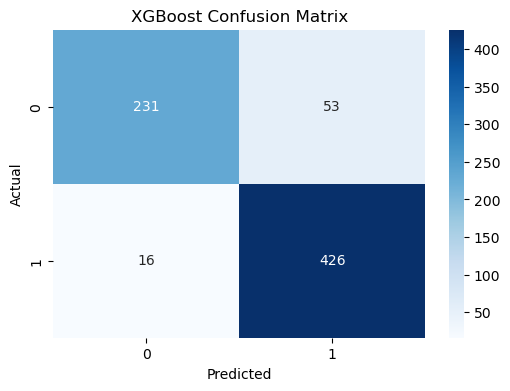

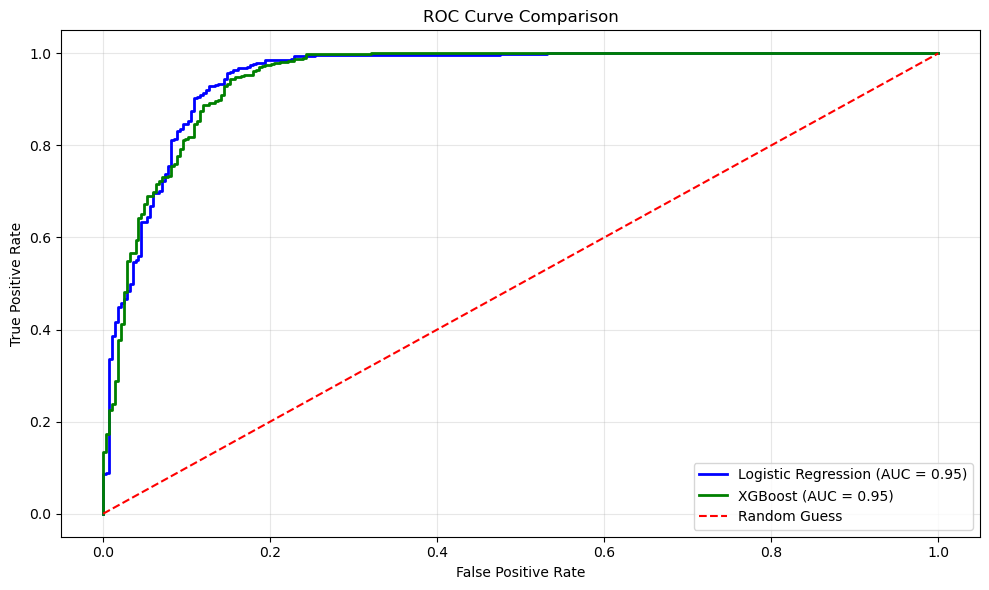

In [215]:
#Step 13: Binary Classification Model Comparison: Logistic Regression vs XGBoost"
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 1. Logistic Regression
log_model = LogisticRegression()
log_model.fit(x_train, y_train)
log_pred = log_model.predict(x_test)
log_proba = log_model.predict_proba(x_test)[:, 1]

# 2. XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)
xgb_proba = xgb_model.predict_proba(x_test)[:, 1]

# --- Evaluation Reports ---
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nLogistic Regression Report:\n", classification_report(y_test, log_pred))
print("\nXGBoost Report:\n", classification_report(y_test, xgb_pred))

# --- Confusion Matrix for XGBoost ---
conf_mat = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# --- ROC Curve & AUC ---
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
auc_log = auc(fpr_log, tpr_log)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_log:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [217]:
import joblib
#After training your xgb_model
joblib.dump(xgb_model, "xgb_dropout_model.pkl")

['xgb_dropout_model.pkl']

##### Step 14: Training and Saving a Simplified XGBoost Model
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# 1) Load & filter
df = pd.read_csv("Students_dropout.csv", sep=";")
df = df[df['Target'].isin(['Graduate','Dropout'])].reset_index(drop=True)
df['Target'] = df['Target'].map({'Graduate':1,'Dropout':0})

# 2) Pick your six features
top6 = [
    "Curricular units 2nd sem (approved)",
    "Curricular units 1st sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 1st sem (grade)",
    "Tuition fees up to date",
    "Scholarship holder"
]

X = df[top6]
y = df['Target']

# 3) Train/test split + scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 4) Retrain XGB on just these six
model6 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model6.fit(X_train, y_train)

# 5) Save both model and scaler
joblib.dump(model6, "xgb_top6_model.pkl")
joblib.dump(scaler, "scaler_top6.pkl")


In [245]:
#Step 15: Save both model and scaler
joblib.dump(model6, "xgb_top6_model.pkl")
joblib.dump(scaler, "scaler_top6.pkl")

['scaler_top6.pkl']

In [247]:
joblib.dump(model6, "xgb_top6_model.pkl")


['xgb_top6_model.pkl']

This code was run to:

- Simplify the model: By selecting a subset of the most relevant features, we can simplify the model and potentially improve its interpretability and performance.
- Deploy the model: By saving the trained model and scaler, we can deploy the model in a production environment and use it to make predictions on new data.
- Improve model efficiency: By using a smaller set of features, we can reduce the computational resources required to train and deploy the model.

Step 16: Hyperparameter Tuning:

Hyperparameter tuning involves adjusting the hyperparameters to optimize the performance of the model. 


In [ ]:
#Step 1: Basic Manual Tuning. Manually tune 1 or 2 Key parameters to see the effect
#Target Parameters: n_estimators:Number of trees (default is 100)
#max_depth of each tree(controls model complexity)


Accuracy: 0.9090909090909091

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       284
           1       0.90      0.96      0.93       442

    accuracy                           0.91       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.91      0.91       726



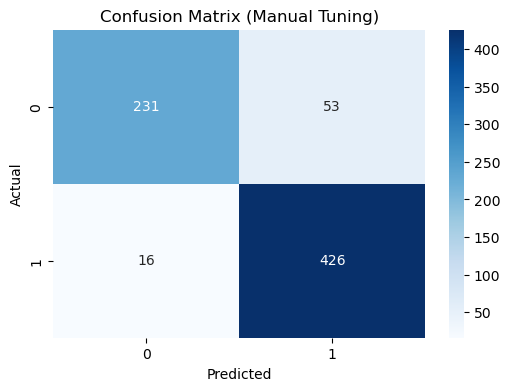

In [219]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Manually tuned model
model = XGBClassifier(
    n_estimators=200,
    max_depth=20,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#Train the model
model.fit(x_train, y_train)

#Predict
y_pred = model.predict(x_test)

#Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Plot the Confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Manual Tuning)')
plt.show()            

| **Metric**    | **Dropout (0)** | **Graduate (1)** | **Macro Avg** | **Weighted Avg** |
| ------------- | --------------- | ---------------- | ------------- | ---------------- |
| **Precision** | 0.93            | 0.90             | 0.91          | 0.91             |
| **Recall**    | 0.83            | 0.96             | 0.89          | 0.91             |
| **F1 Score**  | 0.88            | 0.93             | 0.90          | 0.91             |
| **Accuracy**  |                 |                  | **0.91**      |                  |

 🧠 Insights
✅ The model achieved 91% overall accuracy, indicating excellent performance.

🎯 Precision:
Dropout (0): 93% – very low false positives.
Graduate (1): 90% – reliable positive predictions.

📈 Recall:
Dropout (0): 83% – some at-risk students may still be missed.
Graduate (1): 96% – highly effective at identifying graduates.

⚖️ F1 Score balances precision and recall:
Stronger for graduates, but very good for dropouts as well.

📌 Recommendation
This model is suitable for deployment in an educational system for early dropout detection
and student retention strategies, as it identifies most graduates correctly and maintains 
a strong ability to predict dropouts with reasonable precision.

In [ ]:
#Step 2; GridSearchCV (Exhaustive search)
GridSearch is a method in scikit-learn that automatically searches for the best combination of 
hyperparameters from a grid(list of options you provide). It trains your model on all possible
combinations and tells you which one works best based on a scoring metric like accuracy. 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.9077134986225895

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87       284
           1       0.89      0.97      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.89      0.90       726
weighted avg       0.91      0.91      0.91       726



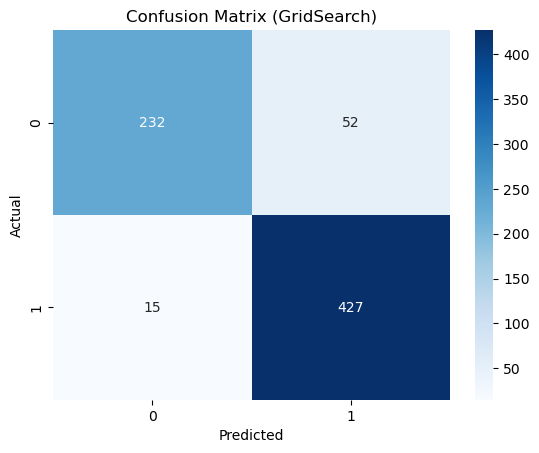

In [221]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#Define a grid of parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth':[3, 5],
    'learning_rate':[0.05, 0.1],
}

#Setup model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#setup GridSearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

#Fit
grid_search.fit(x_train, y_train)

#Best Model
print("Best Parameters:", grid_search.best_params_)

#Predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

#Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

 #Plot the Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GridSearch)')
plt.show()      

| **Metric**    | **Dropout (0)** | **Graduate (1)** | **Macro Avg** | **Weighted Avg** |
| ------------- | --------------- | ---------------- | ------------- | ---------------- |
| **Precision** | 0.94            | 0.89             | 0.92          | 0.91             |
| **Recall**    | 0.82            | 0.97             | 0.89          | 0.91             |
| **F1 Score**  | 0.87            | 0.93             | 0.90          | 0.91             |
| **Accuracy**  |                 |                  | **0.91**      |                  |

📊 Key Takeaways
🔍 Dropout Class (0):

Precision = 0.94: Excellent at avoiding false dropout alerts.

Recall = 0.82: Captures 82% of real dropouts (room to improve).

🎓 Graduate Class (1):

Precision = 0.89, Recall = 0.97: Extremely strong at identifying students who graduate.

📈 Overall Accuracy = 91%:

Consistent with a high-performing model suitable for educational decision-making.

In [ ]:
#STEP3: RandomizedSearchCV(Smarter, Faster)
This is a Hyperparameter tuning technique that randomly samples combinations of Hyperparameters from specified distributions. 
Instead of exhaustively trying all combinations, it tests only a fixed number of random combinations. This makes it faster and more efficient, 
especially when you have a large parameter space. 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters from RandomizedSearch: {'subsample': 0.8, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}
Accuracy: 0.9035812672176309

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       284
           1       0.89      0.96      0.92       442

    accuracy                           0.90       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.90      0.90       726



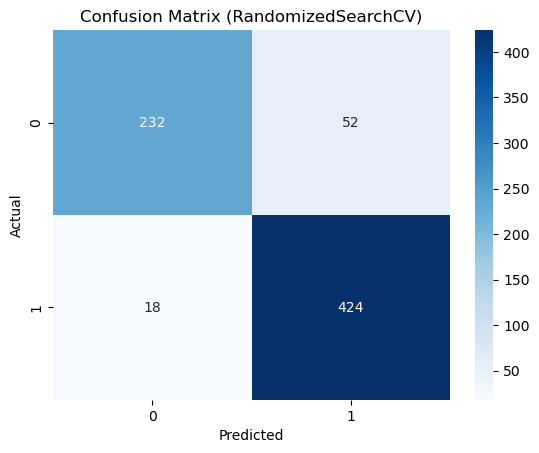

In [223]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#Parameter grid for RandomizedSearch
param_dist = {
       'n_estimators': [100, 200, 300, 400],
       'max_depth': [3, 4, 5, 6, 8],
       'learning_rate': [0.01, 0.05, 0.1, 0.2],
       'subsample': [0.6, 0.8, 1.0],
       'colsample_bytree': [0.6, 0.8, 1.0],
       'gamma': [0, 0.5, 1, 5],
       'reg_lambda': [0.01, 0.1, 1, 10]
}

#Initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

#Randomized model
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,    #Try 20 combinations
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

#Fit
random_search.fit(x_train, y_train)

#Best model and Predictions
print("Best Parameters from RandomizedSearch:", random_search.best_params_)
best_model = random_search.best_estimator_


y_pred = best_model.predict(x_test)

#Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

 #Plot the Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RandomizedSearchCV)')
plt.show()      

In [ ]:
| **Metric**    | **Dropout (0)** | **Graduate (1)** | **Macro Avg** | **Weighted Avg** |
| ------------- | --------------- | ---------------- | ------------- | ---------------- |
| **Precision** | 0.93            | 0.89             | 0.91          | 0.91             |
| **Recall**    | 0.82            | 0.96             | 0.89          | 0.90             |
| **F1 Score**  | 0.87            | 0.92             | 0.90          | 0.90             |
| **Accuracy**  | —               | —                | **0.90**      | —                |

 📊 Interpretation
🔍 Dropout (Class 0):
Precision: 0.93 — Very accurate at identifying true dropouts.
Recall: 0.82 — Slightly lower, meaning a few dropouts may go undetected.

🎓 Graduate (Class 1):
Precision: 0.89, Recall: 0.96 — Strong ability to correctly identify graduating students.

📈 Overall Accuracy: 90.36%
The model is well-balanced, making it reliable for student retention strategies and academic forecasting.

✅ Why It Matters to Stakeholders
This model provides early and confident identification of students at risk of dropping out.
Administrators can use these insights to offer targeted interventions.

In [ ]:
#Step 4: Bayesian Optimization using Optuna ...pip install optuna
Optuna is an open-source hyperparameter optimization framework that uses Bayesian optimization under 
the hood. Instaed of randomly or exhaustively trying all combinations, it learns which regions of the
hyperparameter space are promis

In [225]:
!pip install optuna

[I 2025-07-06 22:57:49,336] A new study created in memory with name: no-name-3c169eed-6f50-4a2f-9e7c-b7edd33f562a
[I 2025-07-06 22:57:55,122] Trial 0 finished with value: 0.9073707638435515 and parameters: {'n_estimators': 1931, 'max_depth': 3, 'learning_rate': 0.20769537780266836, 'subsample': 0.9029468164443122, 'colsample_bytree': 0.830596160517574, 'gamma': 3.7822828635240295, 'reg_lambda': 9.675520484184315}. Best is trial 0 with value: 0.9073707638435515.
[I 2025-07-06 22:57:59,699] Trial 1 finished with value: 0.90633806160603 and parameters: {'n_estimators': 1823, 'max_depth': 6, 'learning_rate': 0.04903776758365541, 'subsample': 0.812157558554473, 'colsample_bytree': 0.9630694071381891, 'gamma': 4.987797831447453, 'reg_lambda': 6.683006728945717}. Best is trial 0 with value: 0.9073707638435515.
[I 2025-07-06 22:58:02,646] Trial 2 finished with value: 0.9097792153837021 and parameters: {'n_estimators': 391, 'max_depth': 3, 'learning_rate': 0.08402938293484583, 'subsample': 0.88

🔥 Best Optuna parameters: {'n_estimators': 2355, 'max_depth': 6, 'learning_rate': 0.15328797478047354, 'subsample': 0.8634498980777645, 'colsample_bytree': 0.6925795740097825, 'gamma': 0.6344743847673423, 'reg_lambda': 4.32756627870633}
🔥 Best CV accuracy: 0.9139123983619205

Test Accuracy: 0.9077134986225895

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       284
           1       0.89      0.96      0.93       442

    accuracy                           0.91       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.91      0.91       726



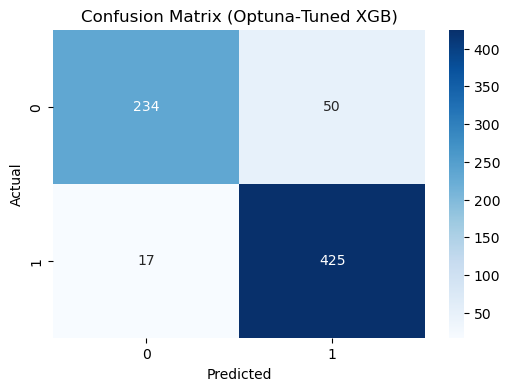

In [231]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth':   trial.suggest_int('max_depth',  3,   8),
        'learning_rate':   trial.suggest_float('learning_rate',   0.01, 0.3),
        'subsample':        trial.suggest_float('subsample',        0.6,  1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6,  1.0),
        'gamma':     trial.suggest_float('gamma',     0,   5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10),
        'use_label_encoder': False,
        'eval_metric':       'logloss'
    }

    model = XGBClassifier(**params, random_state=42)
    # 5‑fold CV on the training set:
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# 1) Create & run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

print("🔥 Best Optuna parameters:", study.best_trial.params)
print("🔥 Best CV accuracy:", study.best_value)

# 2) Train final model with best params
best_params = study.best_trial.params
best_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_model.fit(x_train, y_train)

# 3) Evaluate on your held‑out test set
y_pred = best_model.predict(x_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 4) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Optuna‑Tuned XGB)')
plt.show()



In [ ]:
| **Metric**        | **Dropout (0)** | **Graduate (1)** | **Macro Avg** | **Weighted Avg** |
| ----------------- | --------------- | ---------------- | ------------- | ---------------- |
| **Precision**     | 0.93            | 0.89             | 0.91          | 0.91             |
| **Recall**        | 0.82            | 0.96             | 0.89          | 0.91             |
| **F1 Score**      | 0.87            | 0.93             | 0.90          | 0.91             |

 Interpretation for Decision Makers
✅ Cross-Validation Accuracy: 91.39%
Indicates the model generalizes well across unseen subsets of the data.

✅ Test Accuracy: 90.77%
Confirms real-world performance aligns with training results.

📌 High Recall for Graduates (0.96):
The model is excellent at identifying actual graduates — a key for academic planning and resource allocation.

⚠️ Dropout Recall (0.82):
While strong, a few at-risk students may be missed. A small margin for improvement if early intervention is critical.

🎯 Recommended Use
This model can be integrated into:
Student Monitoring Dashboards
Early Warning Systems
Targeted Retention Campaigns
